<a href="https://colab.research.google.com/github/Toxxi-frank/Deeplearning/blob/main/Lab3_MIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

In [ ]:
import base64, io, time, gym

In [ ]:
import tensorflow as tf
import IPython, functools
import time
import matplotlib.pyplot as plt
from tqdm import tqdm 

In [ ]:
!pip install mitdeeplearning

     |████████████████████████████████| 2.1MB 3.9MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115441 sha256=a10024be063a22d323beb33c260ba2a138200390a5bd9ec2ece9d22b3867f434
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


In [ ]:
import mitdeeplearning as mdl

In [ ]:
env = gym.make('CartPole-v0')
env.seed(1)

[1]

In [ ]:
n_observations = env.observation_space

In [ ]:
print('Environment has observation space= ', n_observations)

Environment has observation space=  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
n_actions = env.action_space.n

In [ ]:
print('Number of possible actions that the agent can choose from = ', n_actions)

Number of possible actions that the agent can choose from =  2


In [ ]:
def create_cartpole_model():
  model= tf.keras.models.Sequential([
            tf.keras.layers.Dense(unist=32, activation='relu'),
            tf.keras.layers.Dense(units=n_actions, activation='None')                         
  ])
  return model

In [ ]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      # First Dense layer
      tf.keras.layers.Dense(units=32, activation='relu'),

      # TODO: Define the last Dense layer, which will provide the network's output.
      # Think about the space the agent needs to act in!
      tf.keras.layers.Dense(units=n_actions, activation=None) # TODO
      # [TODO Dense layer to output action probabilities]
  ])
  return model

In [ ]:
cartpole_model = create_cartpole_model()

In [ ]:
def choose_action(model, observation, single=True):
  # add batch dimension to the observation if only a single example was provided
  observation = np.expand_dims(observation, axis=0) if single else observation

  '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
  logits = model.predict(observation) # TODO
  # logits = model.predict('''TODO''')
  
  '''TODO: Choose an action from the categorical distribution defined by the log 
      probabilities of each possible action.'''
  action = tf.random.categorical(logits, num_samples=1)
  # action = ['''TODO''']

  action = action.numpy().flatten()

  return action[0] if single else action

In [ ]:
class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      '''TODO: update the list of actions with new action'''
      self.actions.append(new_action) # TODO
      # ['''TODO''']
      '''TODO: update the list of rewards with new reward'''
      self.rewards.append(new_reward) # TODO
      # ['''TODO''']

# Helper function to combine a list of Memory objects into a single Memory.
#     This will be very useful for batching.
def aggregate_memories(memories):
  batch_memory = Memory()
  
  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)
  
  return batch_memory

# Instantiate a single Memory buffer
memory = Memory()
  

In [ ]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # update the total discounted reward
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

In [ ]:
def compute_loss(logits, actions, rewards): 
  '''TODO: complete the function call to compute the negative log probabilities'''
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=actions) # TODO
  # neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
  #    logits='''TODO''', labels='''TODO''')
  
  '''TODO: scale the negative log probability by the rewards'''
  loss = tf.reduce_mean( neg_logprob * rewards ) # TODO
  # loss = tf.reduce_mean('''TODO''')
  return loss

In [ ]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    logits = model(observations)
    loss = compute_loss(logits, actions, discounted_rewards)

  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables)) 

In [ ]:
import numpy as np


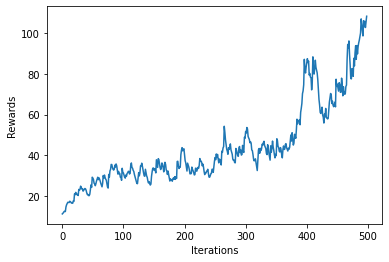

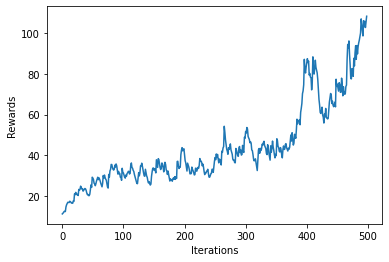

In [ ]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

# instantiate cartpole agent
cartpole_model = create_cartpole_model()

# to track our progress
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i_episode in range(500):

  plotter.plot(smoothed_reward.get())

  # Restart the environment
  observation = env.reset()
  memory.clear()

  while True:
      # using our observation, choose an action and take it in the environment
      action = choose_action(cartpole_model, observation)
      next_observation, reward, done, info = env.step(action)
      # add to memory
      memory.add_to_memory(observation, action, reward)
      
      # is the episode over? did you crash or do so well that you're done?
      if done:
          # determine total reward and keep a record of this
          total_reward = sum(memory.rewards)
          smoothed_reward.append(total_reward)
          
          # initiate training - remember we don't know anything about how the 
          #   agent is doing until it has crashed!
          train_step(cartpole_model, optimizer, 
                     observations=np.vstack(memory.observations),
                     actions=np.array(memory.actions),
                     discounted_rewards = discount_rewards(memory.rewards))
          
          # reset the memory
          memory.clear()
          break
      # update our observatons
      observation = next_observation

In [ ]:
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 200 frames into CartPole-v0.mp4!


In [ ]:
def create_pong_env(): 
  return gym.make("Pong-v0", frameskip=5)
env1 = create_pong_env()
env1.seed(1) # for reproducibility

In [ ]:

print("Environment has observation space =", env.observation_space)

Environment has observation space = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

In [ ]:
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Defines a CNN for the Pong agent
def create_pong_model():
  model = tf.keras.models.Sequential([
    # Convolutional layers
    # First, 32 5x5 filters and 2x2 stride
    Conv2D(filters=32, kernel_size=5, strides=2),

    # TODO: define convolutional layers with 48 5x5 filters and 2x2 stride
    Conv2D(filters=48, kernel_size=5, strides=2), # TODO
    # Conv2D('''TODO'''),

    # TODO: define two convolutional layers with 64 3x3 filters and 2x2 stride
    Conv2D(filters=64, kernel_size=3, strides=2), # TODO
    Conv2D(filters=64, kernel_size=3, strides=2),
    # Conv2D('''TODO'''),

    Flatten(),
    
    # Fully connected layer and output
    Dense(units=128, activation='relu'),
    # TODO: define the output dimension of the last Dense layer. 
    # Pay attention to the space the agent needs to act in
    Dense(units=n_actions, activation=None) # TODO
    # Dense('''TODO''')
  
  ])
  return model

pong_model = create_pong_model()

In [ ]:
def discount_rewards(rewards, gamma=0.99): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # NEW: Reset the sum if the reward is not 0 (the game has ended!)
      if rewards[t] != 0:
        R = 0
      # update the total discounted reward as before
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

In [ ]:

observation = env.reset()
for i in range(30):
  action = np.random.choice(n_actions)
  observation, _,_,_ = env.step(action)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

In [ ]:
next_observation, _,_,_ = env.step(np.random.choice(n_actions))
diff = mdl.lab3.pong_change(observation, next_observation)

f, ax = plt.subplots(1, 3, figsize=(15,15))
for a in ax:
  a.grid(False)
  a.axis("off")
ax[0].imshow(observation); ax[0].set_title('Previous Frame');
ax[1].imshow(next_observation); ax[1].set_title('Current Frame');
ax[2].imshow(np.squeeze(diff)); ax[2].set_title('Difference (Model Input)');

In [ ]:
def collect_rollout(batch_size, env, model, choose_action):

  # Holder array for the Memory buffers
  memories = []

  # Process batches serially by iterating through them
  for b in range(batch_size):

    # Instantiate Memory buffer, restart the environment
    memory = Memory()
    next_observation = env.reset()
    previous_frame = next_observation
    done = False # tracks whether the episode (game) is done or not

    while not done:

      current_frame = next_observation

      '''TODO: determine the observation change.
      Hint: this is the difference between the past two frames'''
      frame_diff = mdl.lab3.pong_change(previous_frame, current_frame) # TODO
      # frame_diff = # TODO

      '''TODO: choose an action for the pong model, using the frame difference, and evaluate'''
      action = choose_action(model, frame_diff) # TODO 
      # action = # TODO
      # Take the chosen action
      next_observation, reward, done, info = env.step(action)

      '''TODO: save the observed frame difference, the action that was taken, and the resulting reward!'''
      memory.add_to_memory(frame_diff, action, reward) # TODO

      previous_frame = current_frame
    
    # Add the memory from this batch to the array of all Memory buffers
    memories.append(memory)
  
  return memories

In [ ]:
test_model = create_pong_model()

# Rollout with single batch
single_batch_size = 1
memories = collect_rollout(single_batch_size, env, test_model, choose_action)
rollout_video = mdl.lab3.save_video_of_memory(memories[0], "Pong-Random-Agent.mp4")

# Play back video of memories
mdl.lab3.play_video(rollout_video)

In [ ]:
learning_rate = 1e-3
MAX_ITERS = 1000 # increase the maximum to train longer
batch_size = 5 # number of batches to run

# Model, optimizer
pong_model = create_pong_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
iteration = 0 # counter for training steps

# Plotting
smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
smoothed_reward.append(0) # start the reward at zero for baseline comparison
plotter = mdl.util.PeriodicPlotter(sec=15, xlabel='Iterations', ylabel='Win Percentage (%)')

# Batches and environment
# To parallelize batches, we need to make multiple copies of the environment.
envs = [create_pong_env() for _ in range(batch_size)] # For parallelization

In [ ]:
games_to_win_episode = 21 # this is set by OpenAI gym and cannot be changed.

# Main training loop
while iteration < MAX_ITERS:

  plotter.plot(smoothed_reward.get())

  tic = time.time()
  # RL agent algorithm. By default, uses serial batch processing.
  # memories = collect_rollout(batch_size, env, pong_model, choose_action)

  # Parallelized version. Uncomment line below (and comment out line above) to parallelize
  memories = mdl.lab3.parallelized_collect_rollout(batch_size, envs, pong_model, choose_action)
  print(time.time()-tic)

  # Aggregate memories from multiple batches
  batch_memory = aggregate_memories(memories)

  # Track performance based on win percentage (calculated from rewards)
  total_wins = sum(np.array(batch_memory.rewards) == 1)
  total_games = sum(np.abs(np.array(batch_memory.rewards)))
  win_rate = total_wins / total_games
  smoothed_reward.append(100 * win_rate)
  
  # Training!
  train_step(
      pong_model,
      optimizer,
      observations = np.stack(batch_memory.observations, 0),
      actions = np.array(batch_memory.actions),
      discounted_rewards = discount_rewards(batch_memory.rewards)
  )

  # Save a video of progress -- this can be played back later
  if iteration % 100 == 0:
    mdl.lab3.save_video_of_model(pong_model, "Pong-v0", 
                                                suffix="_"+str(iteration))
    
  iteration += 1 # Mark next episode

In [ ]:
latest_pong = mdl.lab3.save_video_of_model(
    pong_model, "Pong-v0", suffix="_latest")
mdl.lab3.play_video(latest_pong, width=400)